# Load Data

In [154]:
import pandas as pd

In [155]:
train = pd.read_csv("../../../data/train_data.csv").drop("is_duplicate",axis=1)
train = train[~(train.question2.isna() | train.question1.isna())]

In [156]:
labels_pd = pd.read_csv("../../../data/train_labels.csv")
labels_pd = labels_pd.merge(train[["id"]],on="id",how="inner").is_duplicate
print('Shape of train data:', train.shape)
print('Shape of label data:', labels_pd.shape)

Shape of train data: (323160, 3)
Shape of label data: (323160,)


## create corpus of questions

In [149]:
text_body = pd.concat([train.question1,train.question2]).unique()

In [150]:
line_size = lambda x: len(x) 
vfunc = np.vectorize(line_size)

/Users/jeroen/anaconda3/envs/AML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


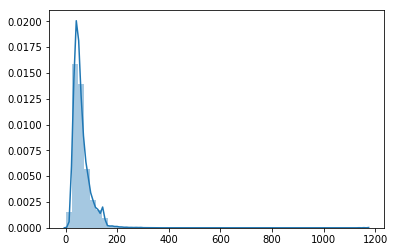

In [151]:
import seaborn as sns
sns.distplot(vfunc(texts))

# Create Splits and Tokanise Data

In [158]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()#nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_body)

sequences_q1 = tokenizer.texts_to_sequences(train.question1)
sequences_q2 = tokenizer.texts_to_sequences(train.question2)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

q1_data = pad_sequences(sequences_q1, maxlen=20)
q2_data = pad_sequences(sequences_q2, maxlen=20)


labels = labels_pd
print('Shape of q1 tensor:', q1_data.shape)
print('Shape of q2 tensor:', q2_data.shape)

print('Shape of label tensor:', labels.shape)

Found 86071 unique tokens.
Shape of q1 tensor: (323160, 20)
Shape of q2 tensor: (323160, 20)
Shape of label tensor: (323160,)


In [159]:
# split the data into a training set and a validation set
indices = np.arange(q1_data.shape[0])
np.random.shuffle(indices)


q1_data = q1_data[indices]
q1_data = q1_data[indices]


labels = labels[indices]

VALIDATION_SPLIT = 0.2

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x1_train = q1_data[:-nb_validation_samples]
x2_train = q2_data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x1_val = q1_data[-nb_validation_samples:]
x2_val = q2_data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

# Load Glove 100d into dict

In [1]:
import os
import numpy as np

In [2]:
GLOVE_DIR = "../../../data/glove/"

In [3]:
embeddings_index = {}
line_num = 0

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
ff = list(f)

In [4]:
f.close()

In [6]:
for line in ff:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    line_num += 1
    if line_num == 400000:
        break;
f.close()

# Create Embedding


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Model

In [ ]:
words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()